# Forward Modeling Uncertainties

Baseline for the uncertainty function to convolve with VICE outputs before plotting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('../src/scripts'))
from utils import group_by_bins

In [2]:
# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (5, 3),
})

## Fitting abundance uncertainties

In [3]:
data = pd.read_csv('../src/data/APOGEE/sample.csv')
data

,APOGEE_ID,RA,DEC,GALR,GALPHI,GALZ,SNREV,TEFF,TEFF_ERR,LOGG,...,FE_H,FE_H_ERR,O_FE,O_FE_ERR,ASTRONN_AGE,ASTRONN_AGE_ERR,LATENT_AGE,LATENT_AGE_ERR,LOG_LATENT_AGE,LOG_LATENT_AGE_ERR
0,2M00000068+5710233,0.002850,57.173164,8.458404,175.658285,-0.040749,282.74594,5031.2637,10.145057,3.456132,...,-0.160280,0.006890,0.113698,0.023433,6.705514,1.256932,3.713866,1.315107,0.569826,0.138561
1,2M00000133+5721163,0.005558,57.354549,11.953869,153.654715,-0.470835,120.29548,4974.6010,15.310856,2.388251,...,-0.509530,0.011012,0.185943,0.039313,4.633531,2.296918,NaN,NaN,NaN,NaN
2,2M00000211+6327470,0.008802,63.463078,12.858291,151.396933,0.169356,169.02042,4681.4634,8.766338,2.245527,...,-0.075011,0.008396,0.027783,0.016560,1.957528,0.724621,NaN,NaN,NaN,NaN
3,2M00000222+5625359,0.009287,56.426662,9.217623,168.311742,-0.185231,129.40749,5049.7686,14.194268,3.291666,...,-0.139290,0.009310,0.087976,0.033478,2.314873,0.814782,1.241603,0.066435,0.093983,0.031293
4,2M00000446+5854329,0.018603,58.909149,10.505168,160.196856,-0.203834,144.98238,4766.6274,10.474075,2.420902,...,-0.082189,0.009157,0.043742,0.020672,2.884895,0.617445,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192915,2M23595669+6131251,359.986225,61.523659,9.939371,163.650440,-0.015894,154.12479,5008.3950,13.106046,2.480740,...,-0.408670,0.009130,-0.031660,0.032894,7.702965,1.889179,NaN,NaN,NaN,NaN
192916,2M23595676+7918072,359.986523,79.302002,9.415115,168.484293,0.676923,446.47790,4311.3926,6.555767,1.731429,...,-0.504450,0.009010,0.287303,0.012854,1.054230,0.843403,NaN,NaN,NaN,NaN
192917,2M23595837+5700444,359.993224,57.012356,10.694221,159.021606,-0.358826,101.53675,4954.1700,15.750314,2.474665,...,-0.333100,0.011422,0.130718,0.037808,4.059420,2.462703,NaN,NaN,NaN,NaN
192918,2M23595886+5726058,359.995265,57.434956,9.328103,167.511337,-0.163006,232.91826,4859.9087,9.050734,2.480687,...,-0.236560,0.007337,0.088913,0.019459,1.907065,0.720498,NaN,NaN,NaN,NaN


In [4]:
def median_standard_error(x, B=1000):
    """
    Use bootstrapping to calculate the standard error of the median.
    
    Parameters
    ----------
    x : array-like
        Data array.
    B : int, optional
        Number of bootstrap samples. The default is 1000.
    
    Returns
    -------
    float
        Standard error of the median.
    """
    rng = np.random.default_rng()
    # Randomly sample input array *with* replacement, all at once
    samples = rng.choice(x, size=len(x) * B, replace=True).reshape((B, len(x)))
    medians = np.median(samples, axis=1)
    # The standard error is the standard deviation of the medians
    return np.std(medians)


def errfit(df, col, deg, err_col='', bins=30, range=None):
    """
    Fit a polynomial to the error in a parameter as a function of that parameter.
    
    Parameters
    ----------
    df : pandas.DataFrame
    col : str
        Name of parameter column
    deg : int
        Degree of polynomial to fit
    err_col : str, optional
        Name of parameter error column. If '', assumed to be col+'_ERR'. The
        default is None.
    bins : int
        Number of bins to divide data by the parameter. The default is 30.
    range : tuple or NoneType, optional
        Parameter range to include data. If None, include the entire data range.
        The default is None.
    
    Returns
    -------
    p : numpy.ndarray
        Polynomial coefficients, highest power first.
    """
    df = df.copy()
    if err_col in ('', None):
        err_col = col + '_ERR'
    if range is not None:
        df = df[(df[col] >= range[0]) & (df[col] < range[1])]
    
    grouped = group_by_bins(df, col, bins=bins)
    # index labels are bin centers
    medians = grouped[err_col].median()
    # standard error of the medians
    median_errs = grouped[err_col].apply(median_standard_error)
    
    # model fit
    p = np.polyfit(medians.index, medians, deg, w=1/median_errs)
    return p

# test
print(np.poly1d(errfit(data, 'FE_H', 1)))

 
-0.00224 x + 0.008455


### [Fe/H]

In [5]:
feh_linear_fit = np.poly1d(errfit(data, 'FE_H', 1))
feh_quad_fit = np.poly1d(errfit(data, 'FE_H', 2))
feh_cubic_fit = np.poly1d(errfit(data, 'FE_H', 3))
feh_quartic_fit = np.poly1d(errfit(data, 'FE_H', 4))

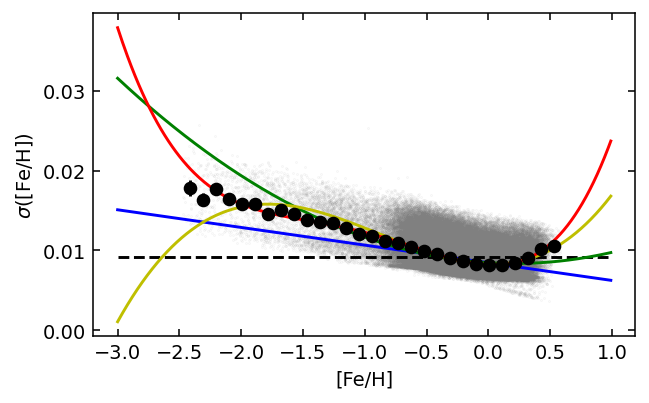

In [19]:
fig, ax = plt.subplots()
# All points
ax.scatter(data['FE_H'], data['FE_H_ERR'], alpha=0.1, s=0.1, c='gray')
# Median bins
grouped = group_by_bins(data, 'FE_H', bins=30)
medians = grouped['FE_H_ERR'].median()
median_errs = grouped['FE_H_ERR'].apply(median_standard_error)
ax.errorbar(medians.index, medians, yerr=median_errs,
            linestyle='none', marker='o', color='k')
# Polynomial fits
xarr = np.arange(-3, 1, 0.01)
ax.plot(xarr, np.ones(xarr.shape[0]) * data['FE_H_ERR'].median(), 'k--')
ax.plot(xarr, feh_linear_fit(xarr), 'b-')
ax.plot(xarr, feh_quad_fit(xarr), 'g-')
ax.plot(xarr, feh_cubic_fit(xarr), 'y-')
ax.plot(xarr, feh_quartic_fit(xarr), 'r-')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'$\sigma$([Fe/H])')
plt.show()

In [20]:
feh_err_fit = feh_linear_fit
print(feh_err_fit)

 
-0.002216 x + 0.008454


### [O/Fe]

In [8]:
ofe_linear_fit = np.poly1d(errfit(data, 'O_FE', 1, range=(-0.25, 0.75)))
ofe_quad_fit = np.poly1d(errfit(data, 'O_FE', 2))
ofe_cubic_fit = np.poly1d(errfit(data, 'O_FE', 3, range=(-0.25, 0.75)))
ofe_quartic_fit = np.poly1d(errfit(data, 'O_FE', 4, range=(-0.25, 0.75)))

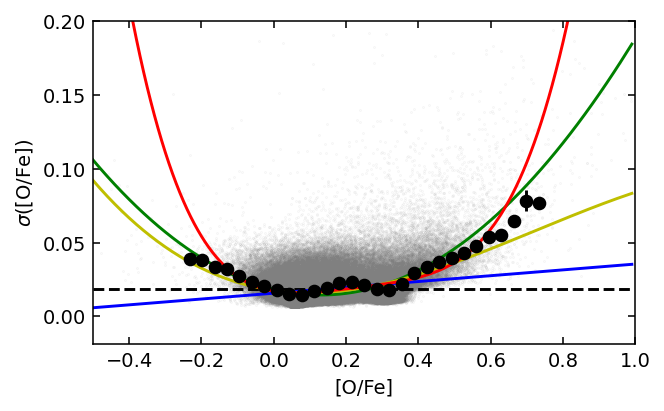

In [21]:
fig, ax = plt.subplots()
# All points
ax.scatter(data['O_FE'], data['O_FE_ERR'], alpha=0.1, s=0.1, c='gray')
# Median bins
grouped = group_by_bins(data, 'O_FE', bins=np.linspace(-0.25, 0.75, 30))
medians = grouped['O_FE_ERR'].median()
median_errs = grouped['O_FE_ERR'].apply(median_standard_error)
ax.errorbar(medians.index, medians, yerr=median_errs,
            linestyle='none', marker='o', color='k')
# Polynomial fits
xarr = np.arange(-.5, 1., 0.01)
ax.plot(xarr, np.ones(xarr.shape[0]) * data['O_FE_ERR'].median(), 'k--')
ax.plot(xarr, ofe_linear_fit(xarr), 'b-')
ax.plot(xarr, ofe_quad_fit(xarr), 'g-')
ax.plot(xarr, ofe_cubic_fit(xarr), 'y-')
ax.plot(xarr, ofe_quartic_fit(xarr), 'r-')
ax.set_xlabel('[O/Fe]')
ax.set_ylabel(r'$\sigma$([O/Fe])')
ax.set_ylim((None, 0.2))
ax.set_xlim((-0.5, 1))
plt.show()

In [22]:
ofe_err_fit = ofe_quad_fit
print(ofe_err_fit)

      2
0.23 x - 0.06009 x + 0.01839


### [O/Fe] error as a function of [Fe/H]

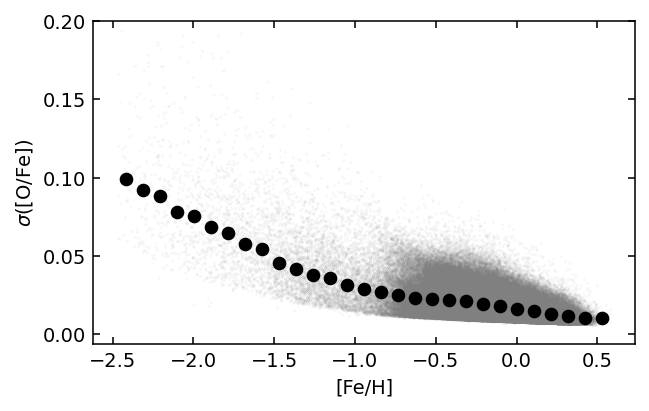

In [37]:
fig, ax = plt.subplots()
# All points
ax.scatter(data['FE_H'], data['O_FE_ERR'], alpha=0.1, s=0.1, c='gray')
# Median bins
grouped = group_by_bins(data, 'FE_H', bins=30)
medians = grouped['O_FE_ERR'].median()
median_errs = grouped['O_FE_ERR'].apply(median_standard_error)
ax.errorbar(medians.index, medians, yerr=median_errs,
            linestyle='none', marker='o', color='k')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'$\sigma$([O/Fe])')
ax.set_ylim((None, 0.2))
# ax.set_xlim((-0.5, 1))
plt.show()

### Age (Leung+ 2023)

Log ages are predicted, so we expect a log-normal distribution.

In [42]:
ages = data.copy().dropna(subset='LOG_LATENT_AGE')
ages

,APOGEE_ID,RA,DEC,GALR,GALPHI,GALZ,SNREV,TEFF,TEFF_ERR,LOGG,...,FE_H,FE_H_ERR,O_FE,O_FE_ERR,ASTRONN_AGE,ASTRONN_AGE_ERR,LATENT_AGE,LATENT_AGE_ERR,LOG_LATENT_AGE,LOG_LATENT_AGE_ERR
0,2M00000068+5710233,0.002850,57.173164,8.458404,175.658285,-0.040749,282.745940,5031.2637,10.145057,3.456132,...,-0.160280,0.006890,0.113698,0.023433,6.705514,1.256932,3.713866,1.315107,0.569826,0.138561
3,2M00000222+5625359,0.009287,56.426662,9.217623,168.311742,-0.185231,129.407490,5049.7686,14.194268,3.291666,...,-0.139290,0.009310,0.087976,0.033478,2.314873,0.814782,1.241603,0.066435,0.093983,0.031293
5,2M00000506+5656353,0.021113,56.943142,10.782479,158.585472,-0.375009,533.233700,4981.5250,10.393430,2.527178,...,-0.427070,0.007515,0.085135,0.025435,2.470570,1.266172,3.081407,1.245757,0.488749,0.181853
6,2M00000535+1504343,0.022311,15.076210,8.381313,174.422544,-0.851532,162.739610,4914.6753,10.838367,3.300559,...,-0.087559,0.008191,0.101433,0.023082,7.667747,0.803533,4.828175,1.366519,0.683783,0.143478
8,2M00000644+5733530,0.026870,57.564724,9.838391,163.937207,-0.220741,173.442660,4757.3230,9.079043,2.575232,...,-0.065082,0.008055,-0.017343,0.017650,2.438767,0.699191,3.041128,1.276580,0.483035,0.236691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192905,2M23595371+8506304,359.973792,85.108459,9.151392,170.735256,0.735716,159.313220,5092.2430,12.708504,3.379881,...,-0.112140,0.008028,0.088694,0.030328,2.993673,0.950974,2.848126,0.609402,0.454559,0.114833
192907,2M23595481+7509560,359.978414,75.165581,8.616469,174.634896,0.229559,498.815370,4824.3516,9.166178,2.718271,...,-0.395240,0.007764,0.189403,0.020430,5.824268,1.271910,6.429371,2.465394,0.808168,0.182784
192908,2M23595490+5704387,359.978770,57.077431,8.585246,174.234470,-0.063616,585.913000,5015.4077,9.502117,2.892750,...,0.050932,0.006490,-0.115146,0.020192,0.720682,0.215777,0.822008,0.116917,-0.085124,0.061572
192913,2M23595553+6339020,359.981416,63.650566,10.086408,162.964682,0.102936,106.809425,5003.4780,14.522411,2.998743,...,0.042468,0.009845,-0.005199,0.031410,0.889073,0.302168,0.884344,0.187022,-0.053379,0.109809


In [12]:
age_linear_fit = np.poly1d(errfit(ages, 'LOG_LATENT_AGE', 1))
age_quad_fit = np.poly1d(errfit(ages, 'LOG_LATENT_AGE', 2))
age_cubic_fit = np.poly1d(errfit(ages, 'LOG_LATENT_AGE', 3))
age_quartic_fit = np.poly1d(errfit(ages, 'LOG_LATENT_AGE', 4))

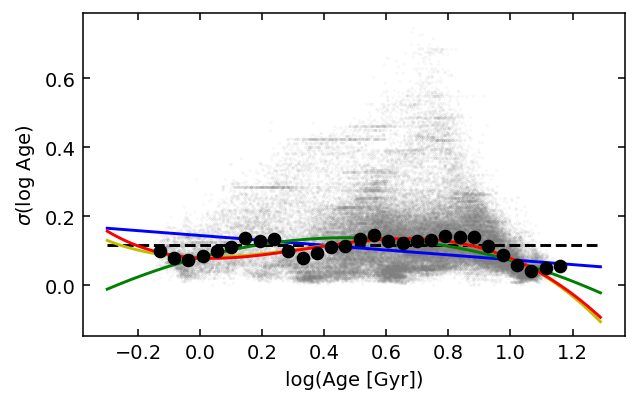

In [43]:
fig, ax = plt.subplots()
# All points
ax.scatter(ages['LOG_LATENT_AGE'], ages['LOG_LATENT_AGE_ERR'], alpha=0.1, s=0.1, c='gray')
# Median bins
grouped = group_by_bins(ages, 'LOG_LATENT_AGE', bins=30)
medians = grouped['LOG_LATENT_AGE_ERR'].median()
median_errs = grouped['LOG_LATENT_AGE_ERR'].apply(median_standard_error)
ax.errorbar(medians.index, medians, yerr=median_errs,
            linestyle='none', marker='o', color='k')
# Polynomial fits
xarr = np.arange(-0.3, 1.3, 0.01)
ax.plot(xarr, np.ones(xarr.shape[0]) * ages['LOG_LATENT_AGE_ERR'].median(), 'k--')
ax.plot(xarr, age_linear_fit(xarr), 'b-')
ax.plot(xarr, age_quad_fit(xarr), 'g-')
ax.plot(xarr, age_cubic_fit(xarr), 'y-')
ax.plot(xarr, age_quartic_fit(xarr), 'r-')
ax.set_xlabel('log(Age [Gyr])')
ax.set_ylabel(r'$\sigma$(log Age)')
plt.show()

In [24]:
log_age_err_fit = age_cubic_fit
print(log_age_err_fit)

         3          2
-0.3858 x + 0.3941 x - 0.01079 x + 0.08109


### astroNN ages (Mackereth+ 2019)

/home/lodubay/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lodubay/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


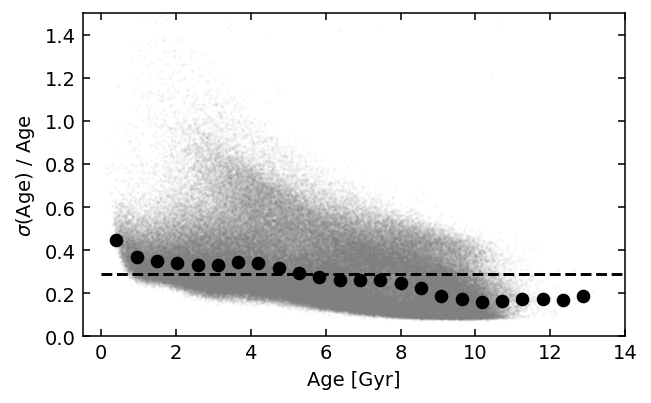

In [53]:
fig, ax = plt.subplots()
data['ASTRONN_AGE_ERR_FRAC'] = data['ASTRONN_AGE_ERR'] / data['ASTRONN_AGE']
# All points
ax.scatter(data['ASTRONN_AGE'], data['ASTRONN_AGE_ERR_FRAC'], alpha=0.1, s=0.1, c='gray')
# Median bins
grouped = group_by_bins(data, 'ASTRONN_AGE', bins=30)
medians = grouped['ASTRONN_AGE_ERR_FRAC'].median()
median_errs = grouped['ASTRONN_AGE_ERR_FRAC'].apply(median_standard_error)
ax.errorbar(medians.index, medians, yerr=median_errs,
            linestyle='none', marker='o', color='k')
ax.plot([0, 14], [data['ASTRONN_AGE_ERR_FRAC'].median(), data['ASTRONN_AGE_ERR_FRAC'].median()], 'k--')
ax.set_xlabel('Age [Gyr]')
ax.set_ylabel(r'$\sigma$(Age) / Age')
ax.set_xlim((-0.5, 14))
ax.set_ylim((0, 1.5))
plt.show()

## Test with VICE output

In [15]:
from utils import multioutput_to_pandas, filter_multioutput_stars, get_bin_centers
from feh_distribution import gen_mdf, box_smooth
from age_distribution import age_distribution

In [16]:
output_name = 'diffusion/insideout/plateau_width1000_slope11'
stars = multioutput_to_pandas(output_name, data_dir='../src/data/migration/')
stars = stars[(stars['mass'] >= 1.) & (stars['age'] > 0.)].copy()

In [25]:
rng = np.random.default_rng()
feh_noise = rng.normal(loc=np.zeros(stars.shape[0]), scale=feh_err_fit(stars['[fe/h]']), size=stars.shape[0])
stars['feh_noisy'] = stars['[fe/h]'] + feh_noise
stars

,formation_time,zone_origin,zone_final,mass,z(fe),z(o),[fe/h],[o/h],[o/fe],z,[m/h],age,analog_id,zfinal,galr_origin,feh_noisy
1600,0.01,0.0,36.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26929294,0.60,0.0,-2.577755
1601,0.01,0.0,76.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26928734,-0.70,0.0,-2.554833
1602,0.01,0.0,18.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26928730,-0.30,0.0,-2.541316
1603,0.01,0.0,36.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26929294,0.60,0.0,-2.580045
1604,0.01,0.0,18.0,125.7098,0.000004,0.000045,-2.557639,-2.107535,0.450104,0.000096,-2.162433,13.19,26928730,-0.30,0.0,-2.566796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111635,13.19,154.0,154.0,3699.6320,0.000235,0.001365,-0.738840,-0.622306,0.116534,0.003196,-0.641534,0.01,34963785,0.03,15.4,-0.743749
2111636,13.19,154.0,154.0,3699.6320,0.000235,0.001365,-0.738840,-0.622306,0.116534,0.003196,-0.641534,0.01,34969499,1.05,15.4,-0.717936
2111637,13.19,154.0,154.0,3699.6320,0.000235,0.001365,-0.738840,-0.622306,0.116534,0.003196,-0.641534,0.01,35020793,-0.25,15.4,-0.735944
2111638,13.19,154.0,154.0,3699.6320,0.000235,0.001365,-0.738840,-0.622306,0.116534,0.003196,-0.641534,0.01,34967104,-0.31,15.4,-0.752836


In [26]:
ofe_noise = rng.normal(loc=np.zeros(stars.shape[0]), scale=ofe_err_fit(stars['[o/fe]']), size=stars.shape[0])
stars['ofe_noisy'] = stars['[o/fe]'] + ofe_noise

# log_age_err_fit = lambda x: np.maximum(np.ones(subset.shape[0]) * data['LOG_LATENT_AGE_ERR'].min(), age_cubic_fit(x))
log_age_noise = rng.normal(loc=np.zeros(stars.shape[0]), scale=log_age_err_fit(np.log10(stars['age'])), size=stars.shape[0])
stars['age_noisy'] = stars['age'] * 10 ** log_age_noise

In [27]:
subset = filter_multioutput_stars(stars, galr_lim=(7, 9), absz_lim=(0, 0.5))
subset

,index,formation_time,zone_origin,zone_final,mass,z(fe),z(o),[fe/h],[o/h],[o/fe],z,[m/h],age,analog_id,zfinal,galr_origin,feh_noisy,ofe_noisy,age_noisy
0,2560,0.01,120.0,70.0,92.30185,1.405125e-07,0.000002,-3.962875,-3.512771,0.450104,0.000004,-3.567669,13.19,26953396,0.16,12.0,-3.980730,0.423748,1.278313e+01
1,2561,0.01,120.0,70.0,92.30185,1.405125e-07,0.000002,-3.962875,-3.512771,0.450104,0.000004,-3.567669,13.19,26953396,0.16,12.0,-3.958473,0.484665,1.312564e+01
2,2562,0.01,120.0,70.0,92.30185,1.405125e-07,0.000002,-3.962875,-3.512771,0.450104,0.000004,-3.567669,13.19,26953396,0.16,12.0,-3.968695,0.486031,1.336850e+01
3,2563,0.01,120.0,70.0,92.30185,1.405125e-07,0.000002,-3.962875,-3.512771,0.450104,0.000004,-3.567669,13.19,26953396,0.16,12.0,-3.998440,0.385895,1.182244e+01
4,2564,0.01,120.0,70.0,92.30185,1.405125e-07,0.000002,-3.962875,-3.512771,0.450104,0.000004,-3.567669,13.19,26953396,0.16,12.0,-3.969809,0.477618,1.312415e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129693,2111115,13.19,89.0,89.0,25541.10000,1.118954e-03,0.004684,-0.061777,-0.086755,-0.024977,0.011590,-0.082049,0.01,35010022,-0.36,8.9,-0.072664,-0.020119,7.097020e-10
129694,2111116,13.19,89.0,89.0,25541.10000,1.118954e-03,0.004684,-0.061777,-0.086755,-0.024977,0.011590,-0.082049,0.01,35005879,-0.30,8.9,-0.066340,0.005038,2.977436e+03
129695,2111117,13.19,89.0,89.0,25541.10000,1.118954e-03,0.004684,-0.061777,-0.086755,-0.024977,0.011590,-0.082049,0.01,35010903,0.11,8.9,-0.058033,-0.023173,1.040447e+06
129696,2111118,13.19,89.0,89.0,25541.10000,1.118954e-03,0.004684,-0.061777,-0.086755,-0.024977,0.011590,-0.082049,0.01,35012371,-0.00,8.9,-0.070037,-0.033065,1.251980e+01


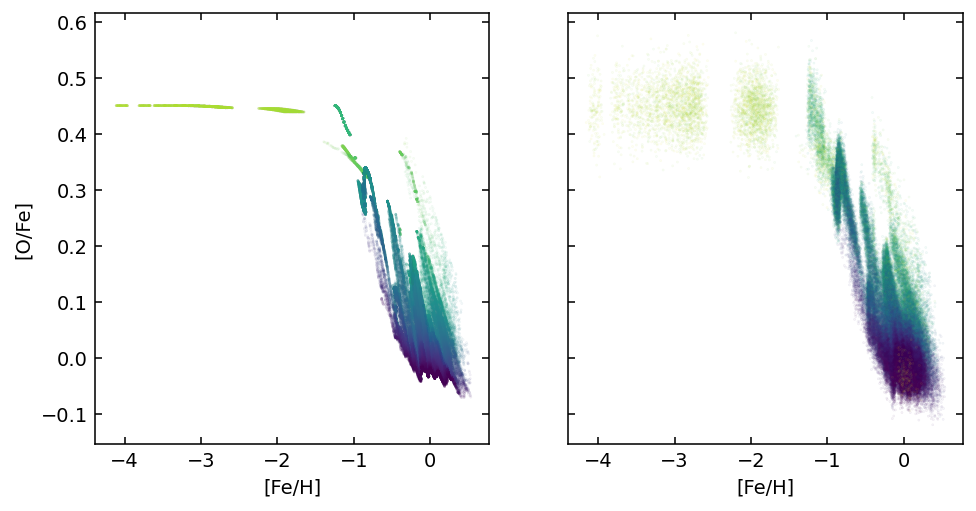

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=140, sharex=True, sharey=True)
axs[0].scatter(subset['[fe/h]'], subset['[o/fe]'], c=subset['age'], s=0.1, alpha=0.1, vmax=15)
axs[0].set_xlabel('[Fe/H]')
axs[0].set_ylabel('[O/Fe]')

axs[1].scatter(subset['feh_noisy'], subset['ofe_noisy'], c=subset['age_noisy'], s=0.1, alpha=0.1, vmax=15)
axs[1].set_xlabel('[Fe/H]')
plt.show()

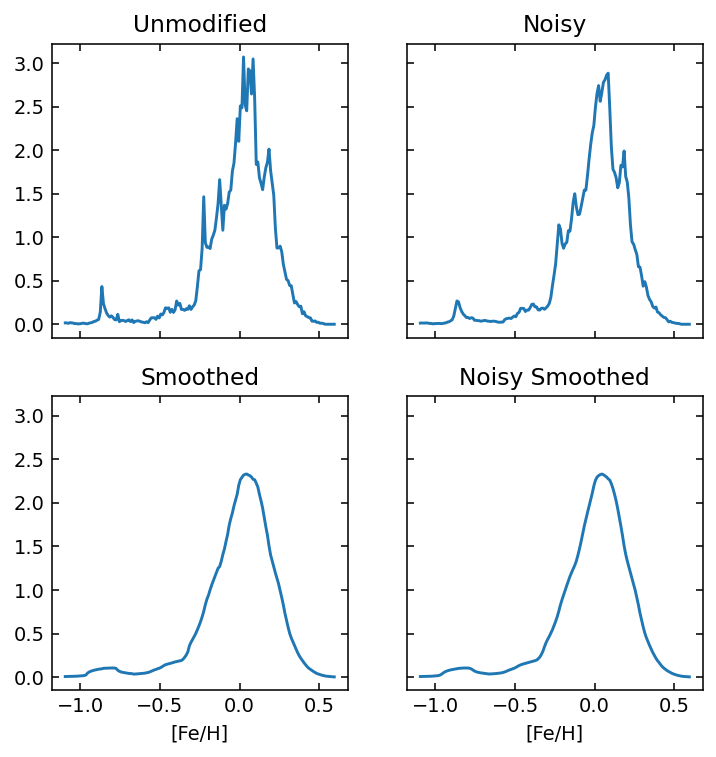

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(6,6), dpi=140, sharex=True, sharey=True)
# original VICE output
mdf_clean, bins = gen_mdf(subset, col='[fe/h]', range=(-1.1, 0.6), bin_width=0.01)
bin_centers = get_bin_centers(bins)
axs[0,0].plot(bin_centers, mdf_clean)
axs[0,0].set_title('Unmodified')
# noisy output
mdf_noisy, bins = gen_mdf(subset, col='feh_noisy', range=(-1.1, 0.6), bin_width=0.01)
axs[0,1].plot(bin_centers, mdf_noisy)
axs[0,1].set_title('Noisy')
# original smoothed
mdf_smooth = box_smooth(mdf_clean, bins, 0.2)
axs[1,0].plot(bin_centers, mdf_smooth)
axs[1,0].set_xlabel('[Fe/H]')
axs[1,0].set_title('Smoothed')
# noisy smoothed
mdf_noisy_smooth = box_smooth(mdf_noisy, bins, 0.2)
axs[1,1].plot(bin_centers, mdf_noisy_smooth)
axs[1,1].set_xlabel('[Fe/H]')
axs[1,1].set_title('Noisy Smoothed')
plt.show()

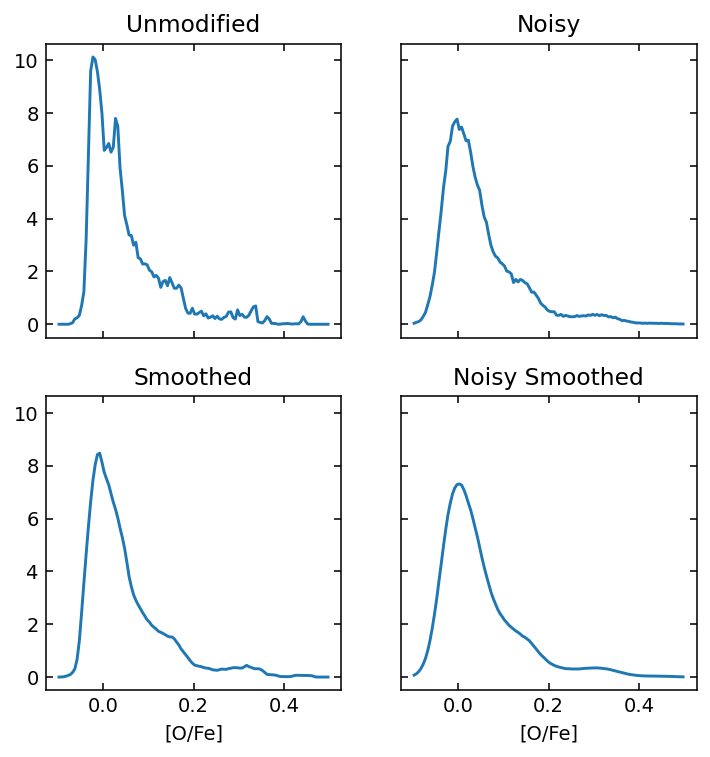

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(6,6), dpi=140, sharex=True, sharey=True)
# original VICE output
mdf_clean, bins = gen_mdf(subset, col='[o/fe]', range=(-0.1, 0.5), bin_width=0.005)
bin_centers = get_bin_centers(bins)
axs[0,0].plot(bin_centers, mdf_clean)
axs[0,0].set_title('Unmodified')
# noisy output
mdf_noisy, bins = gen_mdf(subset, col='ofe_noisy', range=(-0.1, 0.5), bin_width=0.005)
axs[0,1].plot(bin_centers, mdf_noisy)
axs[0,1].set_title('Noisy')
# original smoothed
mdf_smooth = box_smooth(mdf_clean, bins, 0.05)
axs[1,0].plot(bin_centers, mdf_smooth)
axs[1,0].set_xlabel('[O/Fe]')
axs[1,0].set_title('Smoothed')
# noisy smoothed
mdf_noisy_smooth = box_smooth(mdf_noisy, bins, 0.05)
axs[1,1].plot(bin_centers, mdf_noisy_smooth)
axs[1,1].set_xlabel('[O/Fe]')
axs[1,1].set_title('Noisy Smoothed')
plt.show()

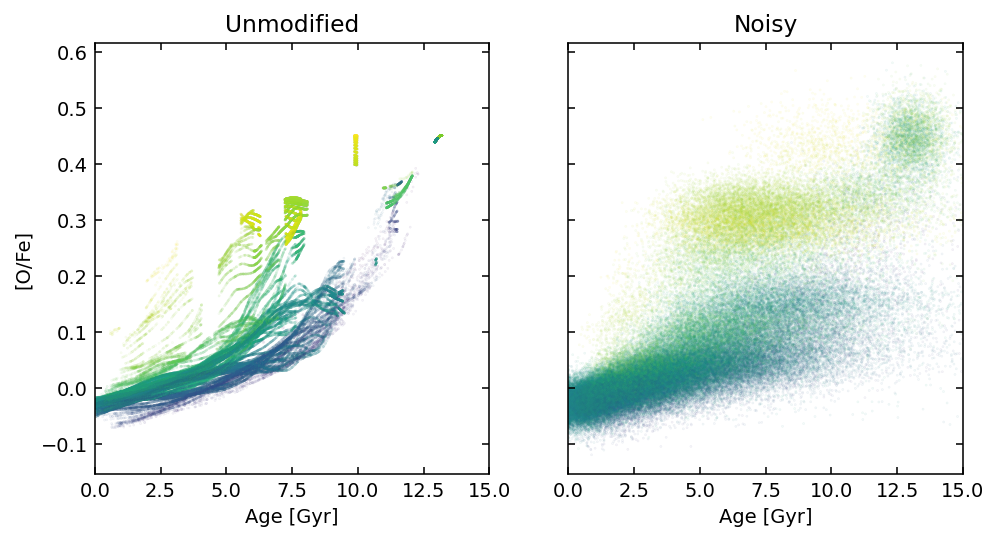

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=140, sharex=True, sharey=True)
axs[0].scatter(subset['age'], subset['[o/fe]'], c=subset['galr_origin'], s=0.1, alpha=0.1)
axs[0].set_xlabel('Age [Gyr]')
axs[0].set_xlim((0, 15))
axs[0].set_ylabel('[O/Fe]')
axs[0].set_title('Unmodified')

axs[1].scatter(subset['age_noisy'], subset['ofe_noisy'], c=subset['galr_origin'], s=0.1, alpha=0.1)
axs[1].set_xlabel('Age [Gyr]')
axs[1].set_title('Noisy')
plt.show()

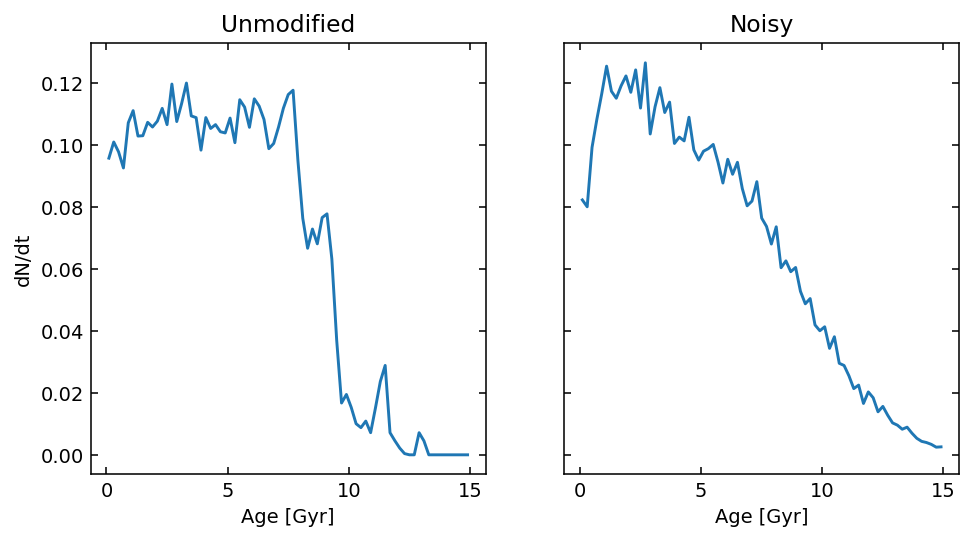

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
# unmodified
adf, bins = age_distribution(subset, bin_width=0.2, end_time=15)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
axs[0].plot(bin_centers, adf)
axs[0].set_title('Unmodified')
# axs[0].hist(subset['age'], bins=bins)
# axs[0].set_xlim((0, 13.5))
axs[0].set_xlabel('Age [Gyr]')
axs[0].set_ylabel('dN/dt')
# noisy
adf_noisy, bins = age_distribution(subset, bin_width=0.2, age_col='age_noisy', end_time=15)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
axs[1].plot(bin_centers, adf_noisy)
axs[1].set_title('Noisy')
# axs[1].hist(subset['age_noisy'], bins=bins)
axs[1].set_xlabel('Age [Gyr]')
plt.show()

## Simpler version: median errors

In [33]:
feh_noise = rng.normal(loc=0., scale=data['FE_H_ERR'].median(), size=subset.shape[0])
subset['feh_noisy_2'] = subset['[fe/h]'] + feh_noise
ofe_noise = rng.normal(loc=0., scale=data['O_FE_ERR'].median(), size=subset.shape[0])
subset['ofe_noisy_2'] = subset['[o/fe]'] + ofe_noise
log_age_noise = rng.normal(loc=0., scale=data['LOG_LATENT_AGE_ERR'].median(), size=subset.shape[0])
subset['age_noisy_2'] = subset['age'] * 10 ** log_age_noise

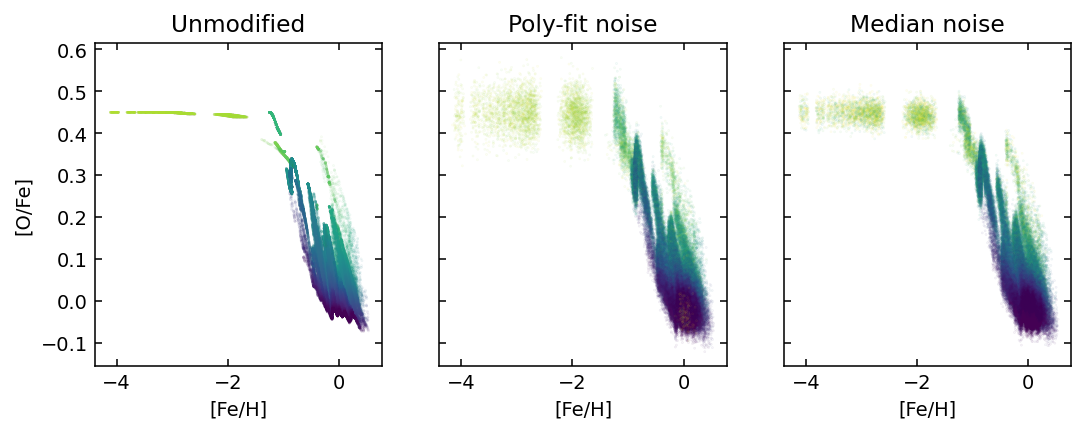

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=140, sharex=True, sharey=True)
axs[0].scatter(subset['[fe/h]'], subset['[o/fe]'], c=subset['age'], s=0.1, alpha=0.1, vmax=15)
axs[0].set_xlabel('[Fe/H]')
axs[0].set_ylabel('[O/Fe]')
axs[0].set_title('Unmodified')

axs[1].scatter(subset['feh_noisy'], subset['ofe_noisy'], c=subset['age_noisy'], s=0.1, alpha=0.1, vmax=15)
axs[1].set_xlabel('[Fe/H]')
axs[1].set_title('Poly-fit noise')

axs[2].scatter(subset['feh_noisy_2'], subset['ofe_noisy_2'], c=subset['age_noisy_2'], s=0.1, alpha=0.1, vmax=15)
axs[2].set_xlabel('[Fe/H]')
axs[2].set_title('Median noise')
plt.show()

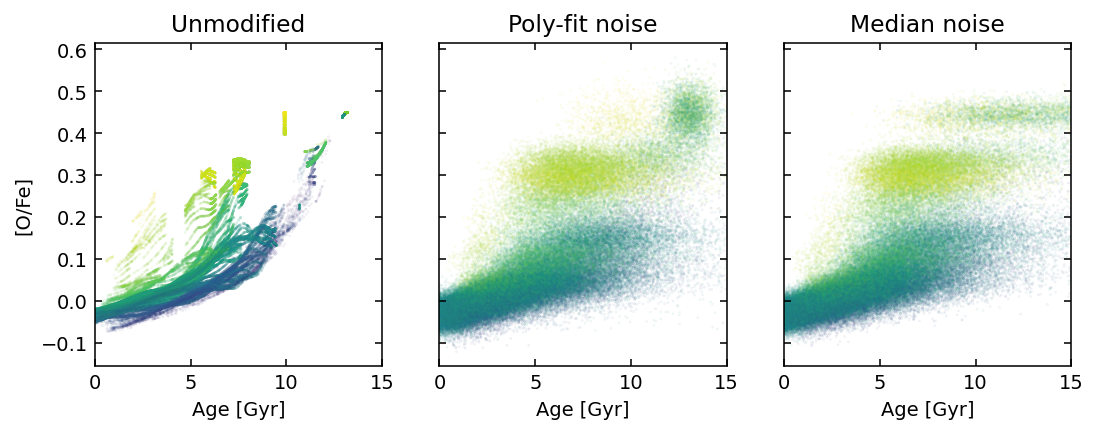

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), dpi=140, sharex=True, sharey=True)
axs[0].scatter(subset['age'], subset['[o/fe]'], c=subset['galr_origin'], s=0.1, alpha=0.1)
axs[0].set_xlabel('Age [Gyr]')
axs[0].set_xlim((0, 15))
axs[0].set_ylabel('[O/Fe]')
axs[0].set_title('Unmodified')

axs[1].scatter(subset['age_noisy'], subset['ofe_noisy'], c=subset['galr_origin'], s=0.1, alpha=0.1)
axs[1].set_xlabel('Age [Gyr]')
axs[1].set_title('Poly-fit noise')

axs[2].scatter(subset['age_noisy_2'], subset['ofe_noisy_2'], c=subset['galr_origin'], s=0.1, alpha=0.1)
axs[2].set_xlabel('Age [Gyr]')
axs[2].set_title('Median noise')
plt.show()